# Starter Notebook

Install and import required libraries

In [ ]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import softmax

from datasets import load_dataset
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    AutoConfig
)

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from peft import PeftModel
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

## Load Tokenizer and Preprocess Data

In [ ]:
base_model = 'roberta-base'
max_length = 384
dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)


# Apply tokenizer after cleaning
def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding='max_length',max_length=max_length)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
print(tokenizer.model_max_length)

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

512


## Token Count Histogram for AGNews

In [ ]:
# Load AG News raw data
#dataset = load_dataset("ag_news", split="train")

# Tokenize a sample of the text (e.g., first 1000 rows)
texts = dataset["text"][:1000]
token_lengths = [len(tokenizer(text)["input_ids"]) for text in texts]

# Print a few examples
for i in range(5):
    print(f"Sample {i}: {token_lengths[i]} tokens → {texts[i][:60]}...")

Sample 0: 39 tokens → Wall St. Bears Claw Back Into the Black (Reuters) Reuters - ...
Sample 1: 57 tokens → Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters ...
Sample 2: 53 tokens → Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - So...
Sample 3: 51 tokens → Iraq Halts Oil Exports from Main Southern Pipeline (Reuters)...
Sample 4: 51 tokens → Oil prices soar to all-time record, posing new menace to US ...


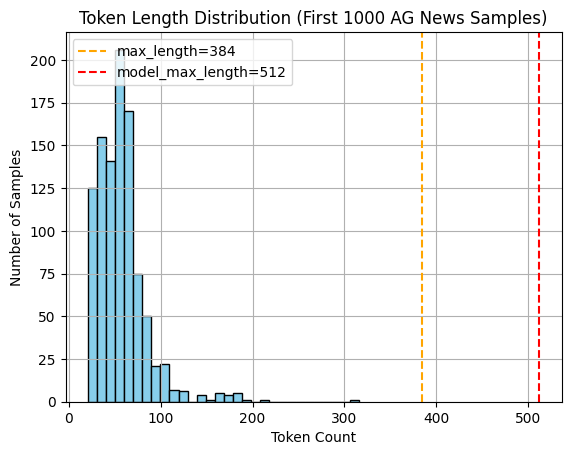

In [ ]:
plt.hist(token_lengths, bins=30, color="skyblue", edgecolor="black")
plt.axvline(384, color="orange", linestyle="--", label="max_length=384")
plt.axvline(512, color="red", linestyle="--", label="model_max_length=512")
plt.title("Token Length Distribution (First 1000 AG News Samples)")
plt.xlabel("Token Count")
plt.ylabel("Number of Samples")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label)
model

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

### Applying inference chunks for unlabelled dataset

In [ ]:
def chunked_predict(text, model, tokenizer, chunk_size=128, stride=64, device="cuda"):

    tokens = tokenizer(text, return_tensors="pt", truncation=False)
    input_ids = tokens["input_ids"][0]

    chunks = [input_ids[i : i + chunk_size] for i in range(0, len(input_ids), stride)]
    all_logits = []
    model.eval()

    for chunk in chunks:
        chunk = chunk.unsqueeze(0).to(device)
        attention_mask = (chunk != tokenizer.pad_token_id).long()

        with torch.no_grad():
            output = model(input_ids=chunk, attention_mask=attention_mask)
            probs = softmax(output.logits, dim=-1)
            all_logits.append(probs.squeeze(0))

    avg_probs = torch.stack(all_logits).mean(dim=0)
    return avg_probs.argmax().item(), avg_probs

## Anything from here on can be modified

In [ ]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [ ]:
# PEFT Config
peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias = 'none',
    target_modules = ['query', 'value'],
    task_type="SEQ_CLS",
)

In [ ]:
peft_model = get_peft_model(model, peft_config)
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): Mod

In [ ]:
#print("Trainable parameters:")
#for name, param in peft_model.named_parameters():
#  if param.requires_grad:
#    print(name)

In [ ]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 925,444 || all params: 125,574,152 || trainable%: 0.7370


## Training Setup

In [ ]:
# To track evaluation accuracy during training
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, average='weighted'),
        'recall': recall_score(labels, preds, average='weighted'),
        'f1': f1_score(labels, preds, average='weighted'),
    }

In [ ]:
# Setup Training args
output_dir = "results"
training_args = TrainingArguments(
    output_dir=output_dir,
    report_to=None,
    eval_strategy='epoch',
    logging_steps=100,
    learning_rate=2e-4,
    num_train_epochs=5,
    #max_steps=1200,
    use_cpu=False,
    dataloader_num_workers=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    optim="adamw_torch",
    gradient_checkpointing=False,
    gradient_checkpointing_kwargs={'use_reentrant':True}
)

def get_trainer(model):
      return  Trainer(
          model=model,
          args=training_args,
          compute_metrics=compute_metrics,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          data_collator=data_collator,
      )

### Start Training

In [ ]:
peft_lora_finetuning_trainer = get_trainer(peft_model)

result = peft_lora_finetuning_trainer.train()

## Evaluate Finetuned Model


### Performing Inference on Custom Input
Uncomment following functions for running inference on custom inputs

In [ ]:
def classify(model, tokenizer, text):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
  output = model(**inputs)

  prediction = output.logits.argmax(dim=-1).item()

  print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
  return id2label[prediction]

In [ ]:
# classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
# classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")

In [ ]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

## Evaluate model through inference chunks

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
peft_model.to(device)
peft_model.eval()

texts = unlabelled_dataset["text"]
preds = []

for i, text in enumerate(texts):
    label, _ = chunked_predict(text, model=peft_model, tokenizer=tokenizer, chunk_size=384, stride=384, device=device)
    preds.append(label)

print("Chunked inference complete.")

df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds
})
df_output.to_csv(os.path.join(output_dir, "v1_chunk_output.csv"), index=False)
print("Predictions saved to v1_chunk_output.csv")



### Evaluate Model (OG Function)

In [ ]:


def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

In [ ]:
# Check evaluation accuracy
_, _ = evaluate_model(peft_model, eval_dataset, True, 8, data_collator)

100%|██████████| 80/80 [00:10<00:00,  7.42it/s]

Evaluation Metric: {'accuracy': 0.2390625}


#### Run Inference on unlabelled dataset

In [ ]:
# Run inference and save predictions
#preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir,"v1_chunk_output.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")


Train & Validation Accuracy over time Plot

In [ ]:
# Access training log history
history = peft_lora_finetuning_trainer.state.log_history

# Extract steps and accuracy
eval_steps = [entry['step'] for entry in history if 'eval_accuracy' in entry]
eval_acc = [entry['eval_accuracy'] for entry in history if 'eval_accuracy' in entry]

# Extract eval loss (optional)
eval_loss = [entry['eval_loss'] for entry in history if 'eval_loss' in entry]

# Plot validation accuracy
plt.plot(eval_steps, eval_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Optional: Plot validation loss too
plt.plot(eval_steps, eval_loss, label='Validation Loss', marker='o', color='orange')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Validation Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:


Abort: 

## Confusion Matrix

In [ ]:
# predict on validation/test set
preds = peft_lora_finetuning_trainer.predict(eval_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(axis=1)

# plot
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

## Token Count Histogram for unlabelled dataset

In [ ]:
# Tokenize a sample of the Kaggle text (first 1000 rows or full if small)
texts = unlabelled_dataset["text"][:1000]  # adjust slice if needed
token_lengths = [len(tokenizer(text)["input_ids"]) for text in texts]

# Print a few examples for verification
for i in range(5):
    print(f"Sample {i}: {token_lengths[i]} tokens → {texts[i][:60]}...")

# Plot the token length distribution
import matplotlib.pyplot as plt

plt.hist(token_lengths, bins=30, color="skyblue", edgecolor="black")
plt.axvline(384, color="orange", linestyle="--", label="max_length=384")
plt.axvline(512, color="red", linestyle="--", label="model_max_length=512")
plt.title("Token Length Distribution (First 1000 Kaggle Test Samples)")
plt.xlabel("Token Count")
plt.ylabel("Number of Samples")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'unlabelled_dataset' is not defined

## Length Distribution Error

In [ ]:
raw_dataset = load_dataset("ag_news", split="train")

# Step 2: Reproduce your original split (must match the one used before training)
raw_split = raw_dataset.train_test_split(test_size=640, seed=42)
raw_eval_dataset = raw_split["test"]

# Step 3: Extract raw texts
val_texts = raw_eval_dataset["text"]

# Step 4: Use your existing predictions
# Make sure y_true and y_pred are already defined based on eval_dataset
# Example:
# preds = trainer.predict(eval_dataset)
# y_true = preds.label_ids
# y_pred = preds.predictions.argmax(axis=1)

# Step 5: Error analysis
df = pd.DataFrame({
    "text": val_texts,
    "true": y_true,
    "pred": y_pred
})

df["length"] = df["text"].apply(len)
errors = df[df["true"] != df["pred"]]

plt.figure(figsize=(10, 5))
plt.hist(errors["length"], bins=30, color='salmon', edgecolor='black')
plt.title("Length Distribution of Misclassified Examples")
plt.xlabel("Text Length (characters)")
plt.ylabel("Number of Errors")
plt.grid(True)
plt.show()

# View top misclassified examples
error_df = df[df["true"] != df["pred"]]
error_df[["text", "true", "pred"]].sample(10)



## Validation F1 Score & Loss over time

In [ ]:
# Get training log history
log_history = peft_lora_finetuning_trainer.state.log_history

# Extract values from log
eval_steps = [entry['step'] for entry in log_history if 'eval_loss' in entry]
eval_loss = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
eval_f1 = [entry['eval_f1'] for entry in log_history if 'eval_f1' in entry]

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# F1 Plot
plt.subplot(1, 2, 1)
plt.plot(eval_steps, eval_f1, marker='o')
plt.title("Validation F1 Score Over Time")
plt.xlabel("Step")
plt.ylabel("F1 Score")
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(eval_steps, eval_loss, marker='o', color='orange')
plt.title("Validation Loss Over Time")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()


Student Model (training off the LoRa model)

In [ ]:

base_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=4)
teacher_model = PeftModel.from_pretrained(base_model, "path/to/lora_checkpoint")
teacher_model.eval()


soft_labels = []

with torch.no_grad():
    for batch in train_dataloader:
        outputs = teacher_model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        soft_labels.append(torch.nn.functional.softmax(outputs.logits / temperature, dim=-1))  # soft targets


In [ ]:


class TinyTransformer(nn.Module):
    def __init__(self, vocab_size=30522, hidden_dim=128, n_heads=2, n_layers=2, num_labels=4, max_len=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.pos_embedding = nn.Embedding(max_len, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=n_heads)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.classifier = nn.Linear(hidden_dim, num_labels)

    def forward(self, input_ids, attention_mask=None):
        pos_ids = torch.arange(0, input_ids.size(1)).unsqueeze(0).to(input_ids.device)
        x = self.embedding(input_ids) + self.pos_embedding(pos_ids)
        x = self.encoder(x)
        x = x.mean(dim=1)
        return self.classifier(x)


Train Student with distillation

In [ ]:
def distillation_loss(student_logits, soft_labels, hard_labels, alpha=0.5, temperature=2.0):
    ce_loss = nn.CrossEntropyLoss()(student_logits, hard_labels)
    kl_loss = nn.KLDivLoss(reduction="batchmean")(
        torch.nn.functional.log_softmax(student_logits / temperature, dim=1),
        soft_labels
    )
    return alpha * ce_loss + (1 - alpha) * (kl_loss * temperature * temperature)


# train the student
student_logits = student_model(input_ids=batch["input_ids"])
loss = distillation_loss(student_logits, soft_labels[idx], hard_labels=batch["labels"])


Save the Student predictions

In [ ]:
student_preds = evaluate_model(student_model, test_dataset, False, 8, data_collator)

# Save predictions
df_student = pd.DataFrame({
    'ID': range(len(student_preds)),
    'Label': student_preds.numpy()
})
df_student.to_csv("results/student_predictions.csv", index=False)

# Save teacher and student model weights
torch.save(teacher_model.state_dict(), "results/teacher_model.pt")
torch.save(student_model.state_dict(), "results/student_model.pt")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

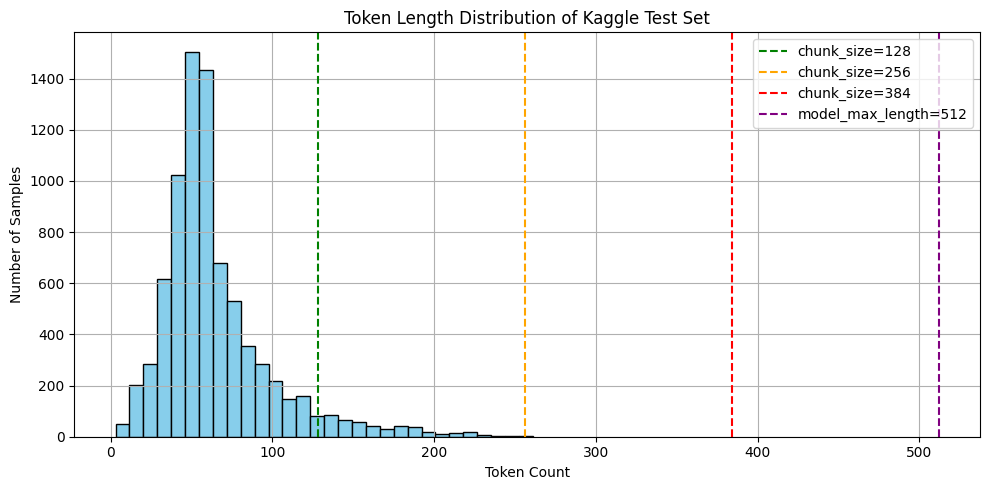

In [ ]:
df = pd.read_pickle("/content/test_unlabelled.pkl")

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tokenize and measure input lengths
token_lengths = [len(tokenizer(text)["input_ids"]) for text in df["text"]]

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.hist(token_lengths, bins=30, color="skyblue", edgecolor="black")
plt.axvline(128, color="green", linestyle="--", label="chunk_size=128")
plt.axvline(256, color="orange", linestyle="--", label="chunk_size=256")
plt.axvline(384, color="red", linestyle="--", label="chunk_size=384")
plt.axvline(512, color="purple", linestyle="--", label="model_max_length=512")
plt.title("Token Length Distribution of Kaggle Test Set")
plt.xlabel("Token Count")
plt.ylabel("Number of Samples")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()